<a href="https://colab.research.google.com/github/TomazFilgueira/UFRN-ML-2025-1-AutoParts_Classification/blob/main/Iracing_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import standard libraries for randomness, deep copying, and numerical operations
import random
import numpy as np
from copy import deepcopy

# Import libraries for image processing and data manipulation
from PIL import Image
import pandas as pd

# Import PyTorch core and utilities for deep learning
import torch
import torch.optim as optim  # Optimization algorithms
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional API for non-parametric operations

# Import PyTorch utilities for data loading and transformations
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype

# Import dataset handling and learning rate schedulers
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Import visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set matplotlib style for better visuals
plt.style.use('fivethirtyeight')

In [5]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()),
                          'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

In [3]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 4)  # Changed from 3 to 4 classes
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (4)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Import Data folder

dataset_iracing/

 - reta
 - freada_apex
 - saida_curva
 - freada

# Visualize first image

In [4]:
def figure1(folder='train_dataset_iracing'):
    cornering = Image.open(f'{folder}/curva_apex/curva (1).jpg')
    braking = Image.open(f'{folder}/freada/freada (2).jpg')
    accelerating = Image.open(f'{folder}/saida_curva/saida_curva (1).jpg')
    straight = Image.open(f'{folder}/reta/reta (1).jpg')

    images = [cornering, braking, accelerating, straight]
    titles = ['cornering', 'braking', 'accelerating', 'straight']

    fig, axs = plt.subplots(1, 4, figsize=(12, 5))
    for ax, image, title in zip(axs, images, titles):
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)

    return fig

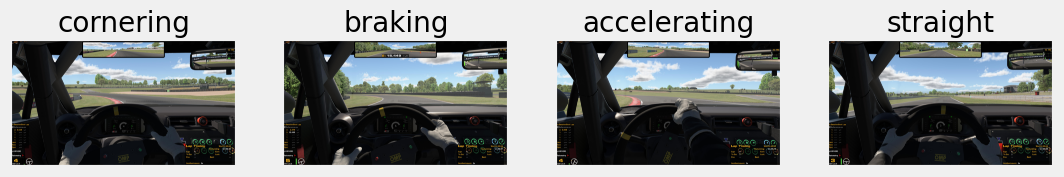

In [5]:
fig = figure1()

# Data Preparation

## ImageFolder

In [4]:
# Compose a sequence of preprocessing transforms
# 1) Resize images to 28×28 pixels
# 2) Ensure output is a PIL/torchvision Image (dropping any alpha channel)
# 3) Convert pixel values to float32 and scale from [0–255] to [0.0–1.0]
temp_transform = Compose([
    Resize([28,28]),                        # Resize each image to 28×28
    ToImage(),                         # Convert tensor back to PIL Image (enforces RGB)
    ToDtype(torch.float32, scale=True) # Cast to float32 and normalize pixel range
])

# Create an ImageFolder dataset from the 'rps' directory
# Images are grouped by subfolder name as class labels, and each image is transformed
temp_dataset = ImageFolder(
    root='train_dataset_iracing',
    transform=temp_transform          # Apply the preprocessing pipeline to every image
)

In [5]:
# the second element of this tuple is the label
temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 28, 28]), 0)

In [6]:
# Get total number of samples in the dataset
dataset_size = len(temp_dataset)
print(f"Dataset size: {dataset_size} images")

# Get number of classes
num_classes = len(temp_dataset.classes)
print(f"Number of classes: {num_classes}")

Dataset size: 7926 images
Number of classes: 4


## Standardization

To standardize data points, we need to learn their **mean** and **standard** deviation first.

To compute these, we need to **load** the data.

In [7]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

In [10]:
# Each column represents a channel
# first row is the number of data points
# second row is the the sum of mean values
# third row is the sum of standard deviations
first_images, first_labels = next(iter(temp_loader))
Architecture.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [ 3.9764,  4.1799,  4.3648],
        [ 3.9146,  4.2255,  4.5494]])

In [ ]:
# we can compute the average mean value and the average standard deviation, per channel.
# make_normalizer() is a method that takes a data loader and returns an instance of the Normalize() transform
normalizer = Architecture.make_normalizer(temp_loader)
normalizer

In [5]:
# Save normalization values as normalize2 (as tensors)
normalizer = Normalize(
    mean=torch.tensor([0.2628, 0.2793, 0.2886]),
    std=torch.tensor([0.2412, 0.2640, 0.2837]),
    inplace=False
)
normalizer  

Normalize(mean=[tensor(0.2628), tensor(0.2793), tensor(0.2886)], std=[tensor(0.2412), tensor(0.2640), tensor(0.2837)], inplace=False)

In [6]:
# Define a pipeline of image transformations:
# 1) Resize each image to 28×28 pixels
# 2) Ensure the output is a PIL/torchvision image (dropping any alpha channel)
# 3) Cast pixels to float32 and scale from [0–255] to [0.0–1.0]
# 4) Apply the user-defined normalization (e.g., mean/std normalization)
composer = Compose([
    Resize([28,28]),                         # Resize to 28×28
    ToImage(),                          # Convert to PIL Image in RGB
    ToDtype(torch.float32, scale=True), # Cast to float32 and normalize to [0,1]
    normalizer                          # Apply custom normalization transform
])

# Instantiate training and validation datasets from folders:
# - 'train_dataset_iracing' contains subfolders per class for training
# - 'test_dataset_iracing' likewise for validation
train_data = ImageFolder(root='train_dataset_iracing', transform=composer)
val_data   = ImageFolder(root='test_dataset_iracing', transform=composer)

# Wrap datasets in DataLoaders for batching and shuffling:
# - batch_size=16 yields mini-batches of 16 images
# - shuffle=True randomizes training order each epoch
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=16)  # no shuffle for validation

In [14]:
def figure2(first_images, first_labels):
    fig, axs = plt.subplots(1, 6, figsize=(12, 4))
    titles = ['cornering', 'braking', 'accelerating', 'straight']
    for i in range(6):
        image, label = ToPILImage()(first_images[i]), first_labels[i]
        axs[i].imshow(image)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(titles[label], fontsize=12)
    fig.tight_layout()
    return fig

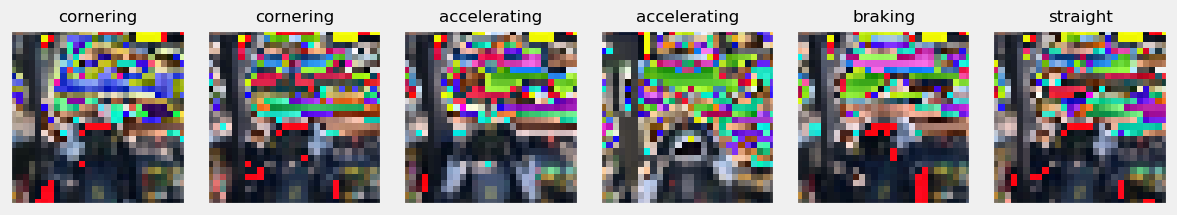

In [15]:
torch.manual_seed(88)
first_images, first_labels = next(iter(train_loader))

fig = figure2(first_images, first_labels)

# 1- Base Model

* n_features=5
* dropout probability p=0.3
* learn rate = 3e-4

# Model Configuration


In [10]:
torch.manual_seed(13)

# Model/Architecture
model_cnn2 = CNN2(n_feature=5, p=0.3)

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=3e-4)

# Model training

In [11]:
arch_cnn2 = Architecture(model_cnn2,
                        multi_loss_fn,
                        optimizer_cnn2)
arch_cnn2.set_loaders(train_loader, val_loader)
arch_cnn2.train(8)

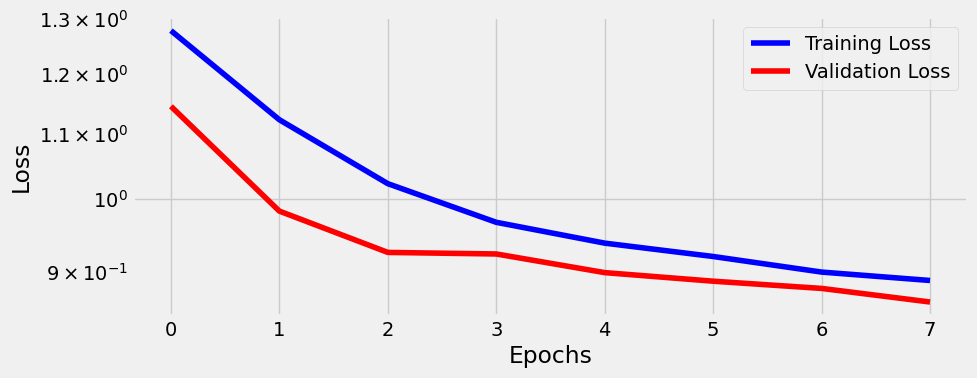

In [12]:
#Save the model
torch.save(model_cnn2.state_dict(), 'base_model_cnn2.pth')
fig = arch_cnn2.plot_losses()

It took 54 minutes to go over 8 epochs - model with 4 classes

# Visualizing Filters

torch.Size([5, 3, 3, 3])


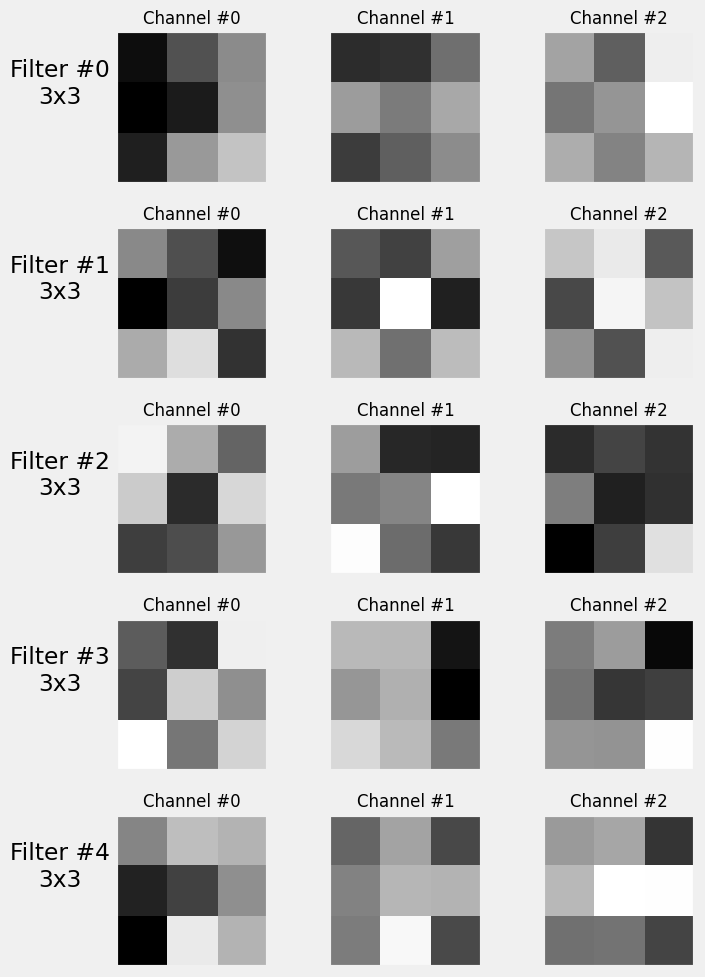

In [33]:
print(model_cnn2.conv1.weight.shape)
fig = arch_cnn2.visualize_filters('conv1')

torch.Size([5, 5, 3, 3])


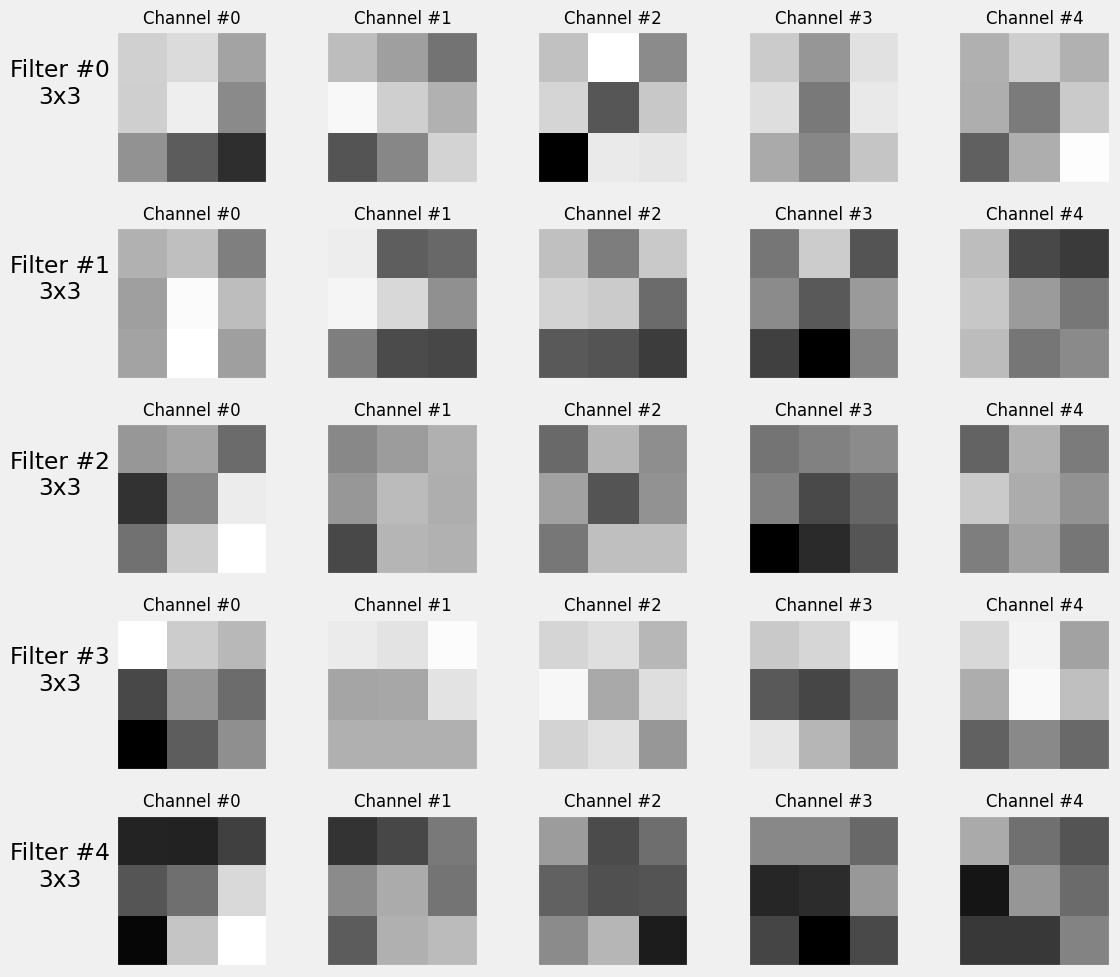

In [35]:
print(model_cnn2.conv2.weight.shape)
fig = arch_cnn2.visualize_filters('conv2')

In [40]:
featurizer_layers = ['conv1','conv2', 'relu1', 'maxp1','maxp2', 'flatten']
classifier_layers = ['fc1', 'relu2', 'fc2']

arch_cnn2.attach_hooks(
  layers_to_hook=featurizer_layers + classifier_layers
)

images_batch, labels_batch = next(iter(val_loader))
logits = arch_cnn2.predict(images_batch)
predicted = np.argmax(logits, 1)

arch_cnn2.remove_hooks()

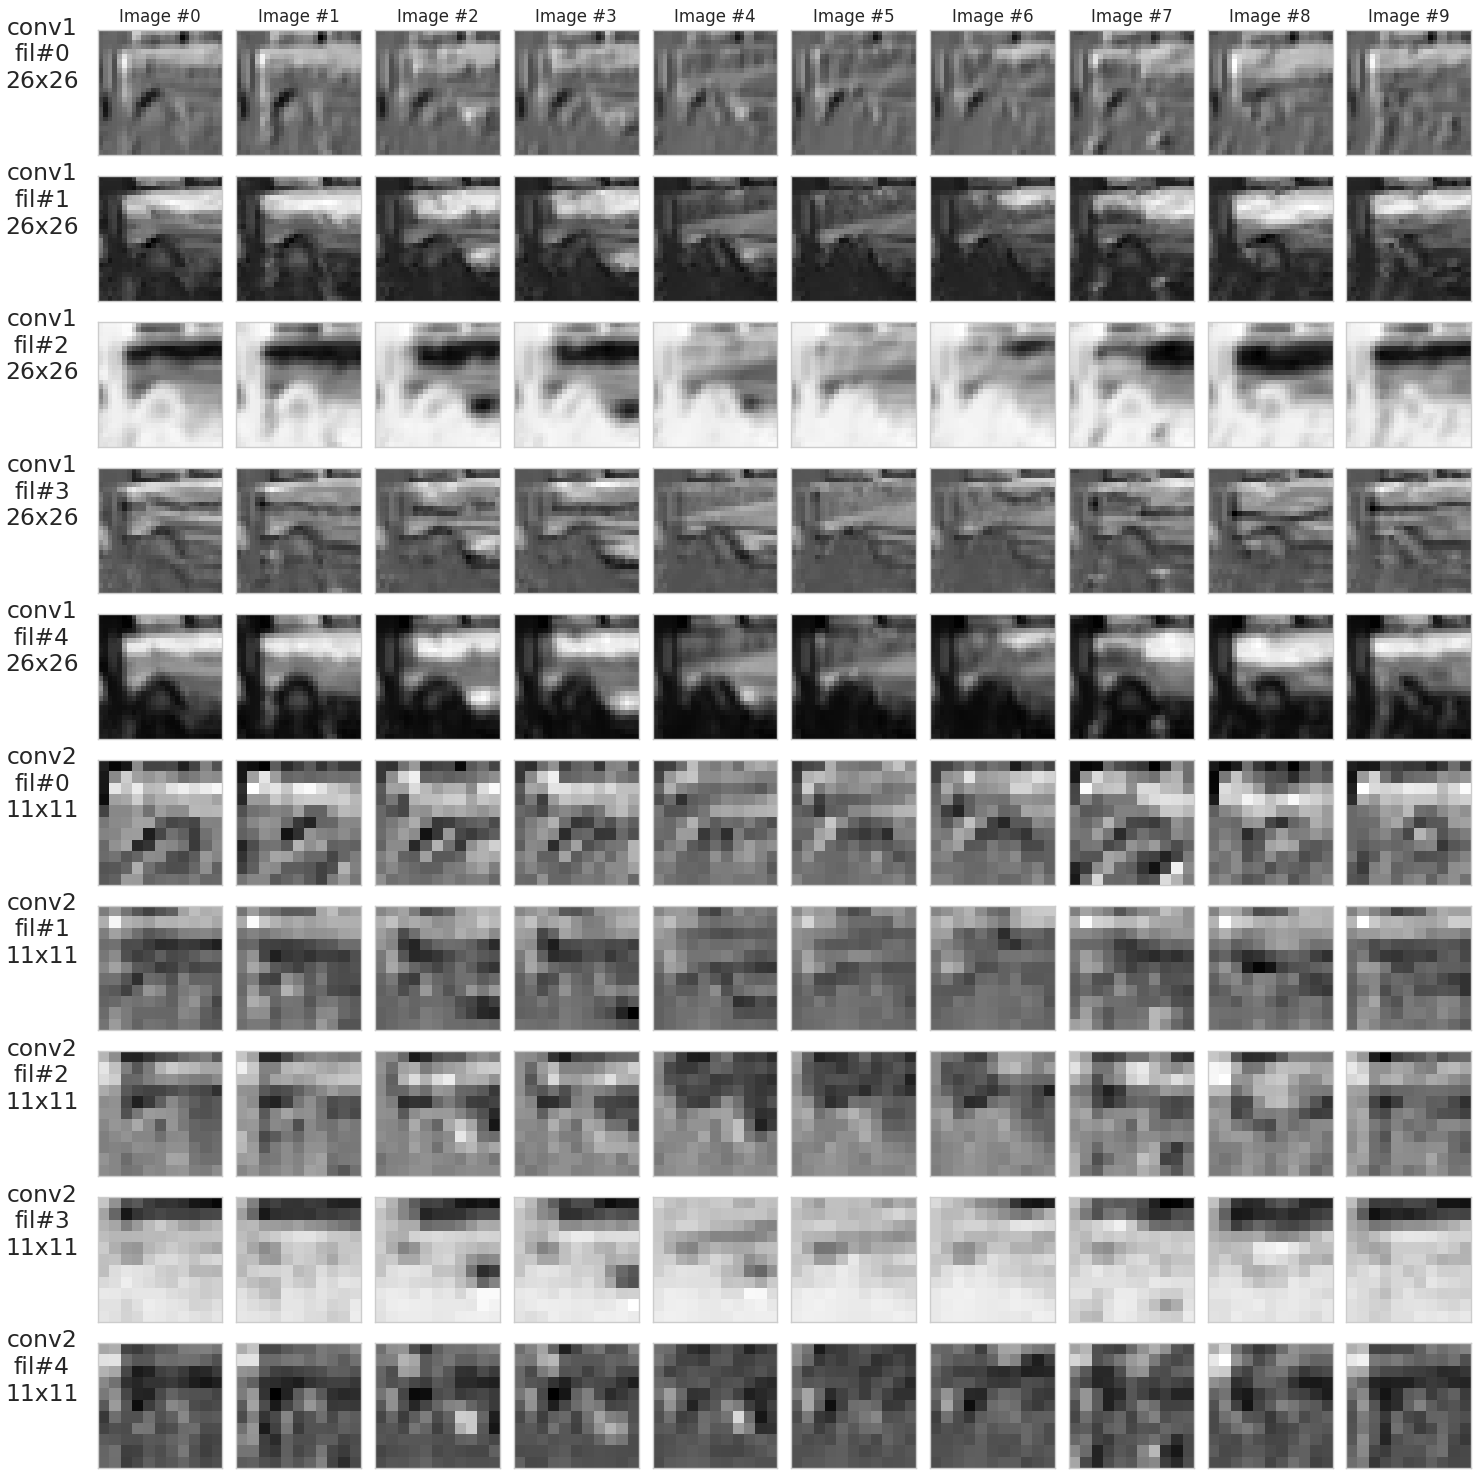

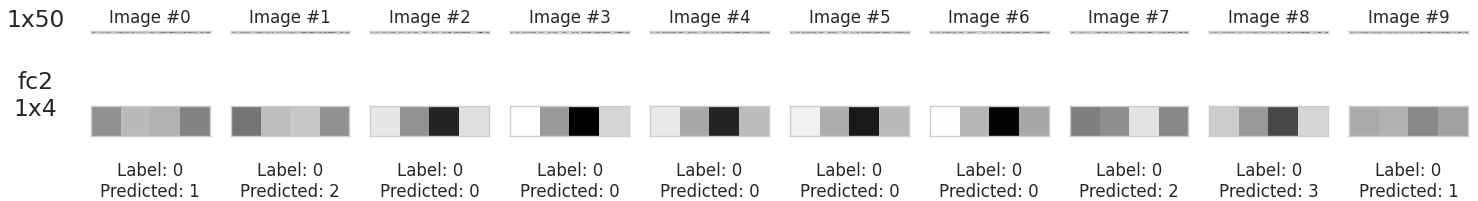

In [44]:
with plt.style.context('seaborn-v0_8-whitegrid'):
    fig_maps1 = arch_cnn2.visualize_outputs(featurizer_layers)
    fig_maps2 = arch_cnn2.visualize_outputs(
                  classifier_layers, y=labels_batch, yhat=predicted
                )


# Accuracy

In [45]:
Architecture.loader_apply(val_loader,
                          arch_cnn2.correct)

tensor([[182, 264],
        [ 46, 196],
        [661, 699],
        [ 33, 254]])

In [47]:
(lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader,
                                                                arch_cnn2.correct).sum(axis=0))

0.6525123849964615

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get all predictions and true labels from the validation set
all_preds = []
all_labels = []

arch_cnn2.model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        logits = arch_cnn2.predict(images)
        preds = np.argmax(logits, axis=1)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())


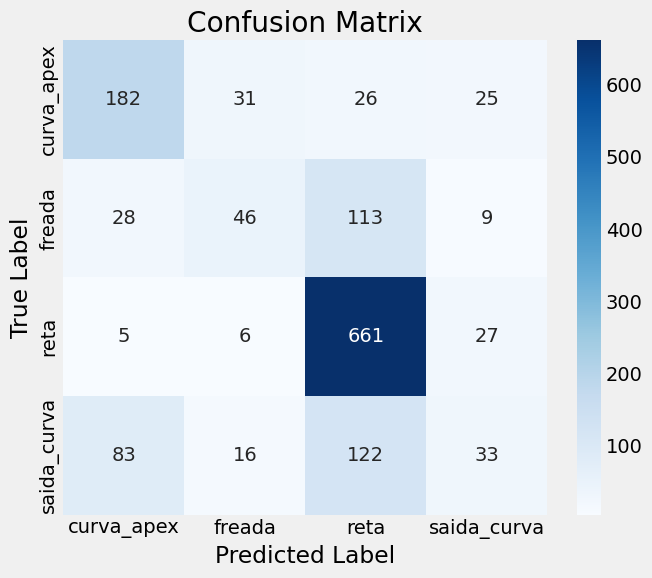

In [ ]:
# Plot confusion matrix using seaborn heatmap
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_data.classes, yticklabels=val_data.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Second Task - base model + n_features change

In this task we will analyze model output varying two times:

1. n_feature = 3
1. n_feature = 10

we will keep dropout probability p=0.3 and lear rate = 3e-4


## Model Training

In [92]:
torch.manual_seed(13)

# Model/Architecture
model2_cnn2 = CNN2(n_feature=3, p=0.3) #changed n_feature from 5 to 3

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
optimizer2_cnn2 = optim.Adam(model2_cnn2.parameters(), lr=3e-4)

In [93]:
arch2_cnn2 = Architecture(model2_cnn2,
                        multi_loss_fn,
                        optimizer2_cnn2)
arch2_cnn2.set_loaders(train_loader, val_loader)
arch2_cnn2.train(8)

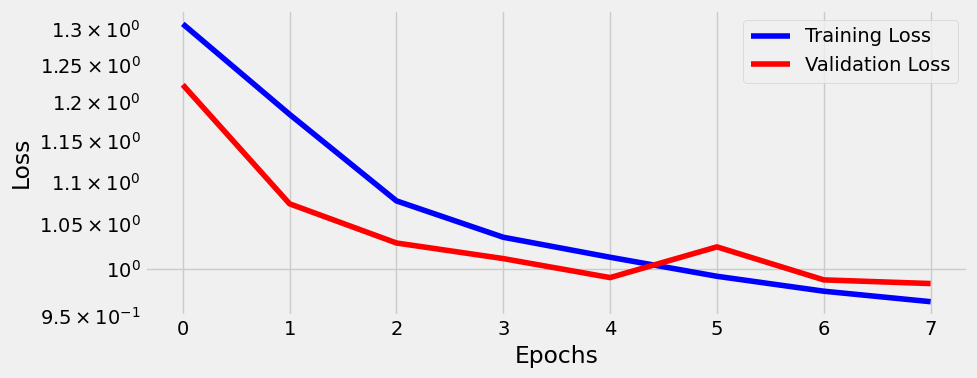

In [112]:
torch.save(model2_cnn2.state_dict(), 'model2_cnn2.pth')

fig = arch2_cnn2.plot_losses()

model 2 took 52 minutes to train its model in 8 epochs

## Model 2 - Visualize layers

In [95]:
featurizer_layers = ['conv1','conv2', 'relu1', 'maxp1','maxp2', 'flatten']
classifier_layers = ['fc1', 'relu2', 'fc2']

arch2_cnn2.attach_hooks(
  layers_to_hook=featurizer_layers + classifier_layers
)

images_batch, labels_batch = next(iter(val_loader))
logits = arch2_cnn2.predict(images_batch)
predicted = np.argmax(logits, 1)

arch2_cnn2.remove_hooks()

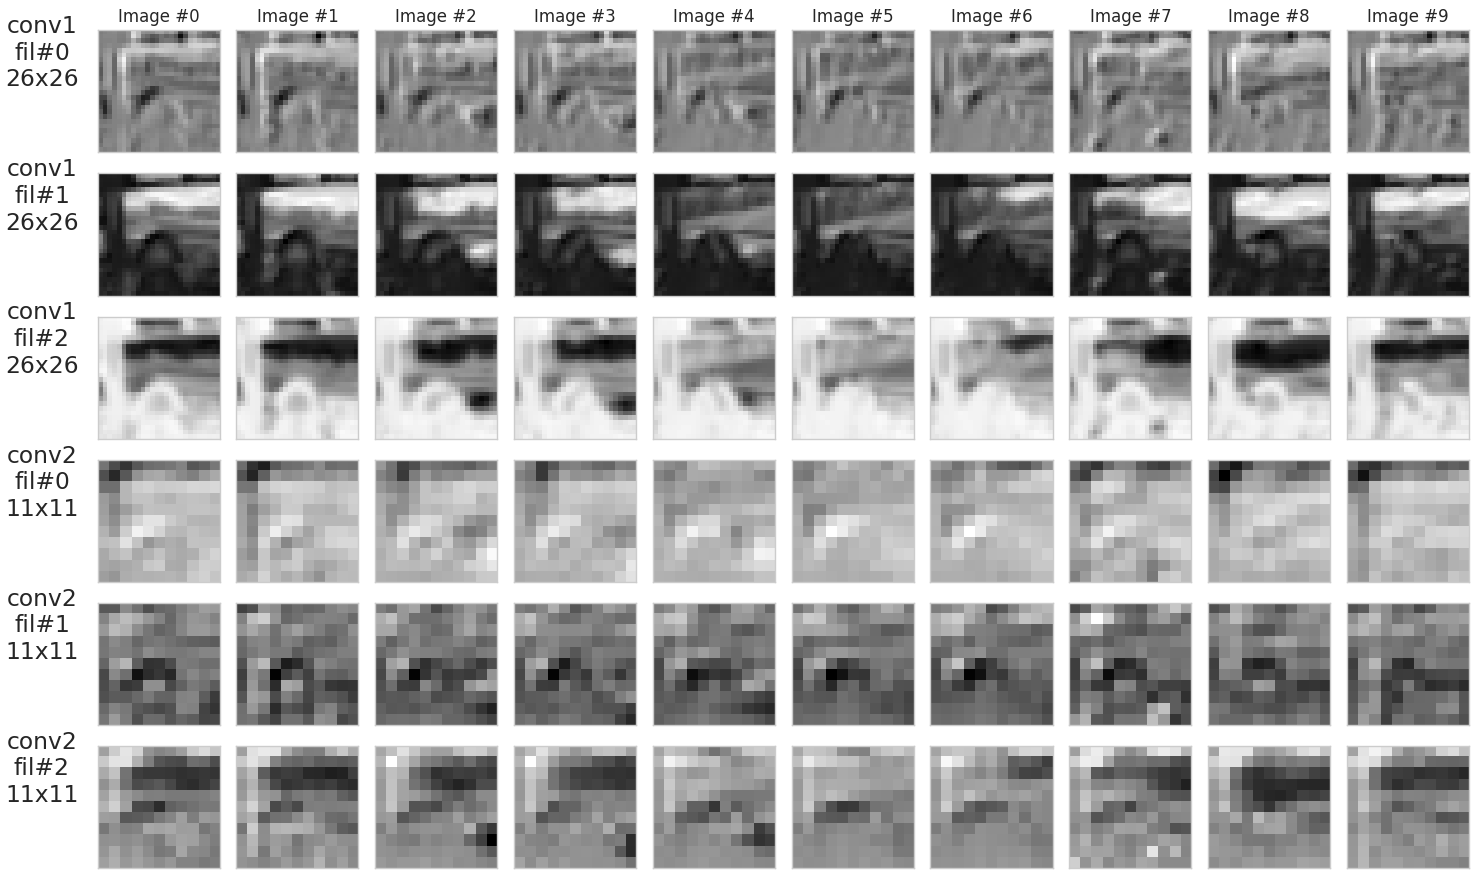

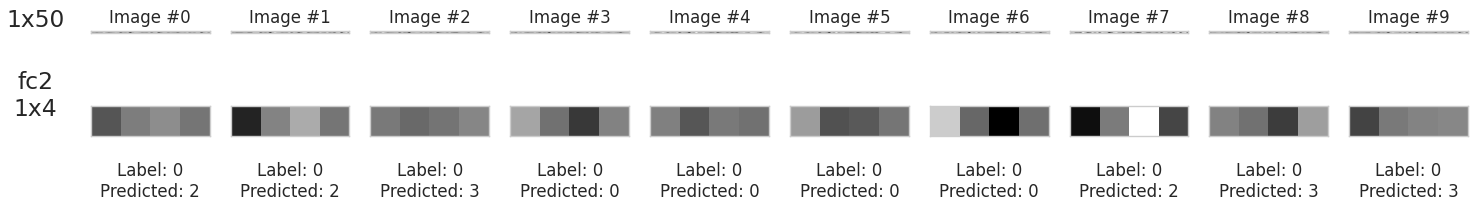

In [96]:
with plt.style.context('seaborn-v0_8-whitegrid'):
    fig_maps1 = arch2_cnn2.visualize_outputs(featurizer_layers)
    fig_maps2 = arch2_cnn2.visualize_outputs(
                  classifier_layers, y=labels_batch, yhat=predicted
                )

## Model 2 Accuracy

In [97]:
correct_counts = Architecture.loader_apply(val_loader, arch2_cnn2.correct)
correct_counts

tensor([[147, 264],
        [ 20, 196],
        [695, 699],
        [ 32, 254]])

tensor([[147, 264],
        [ 20, 196],
        [695, 699],
        [ 32, 254]]

In [98]:

# Get all predictions and true labels from the validation set
all_preds2 = []
all_labels2 = []

arch2_cnn2.model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        logits = arch2_cnn2.predict(images)
        preds = np.argmax(logits, axis=1)
        all_preds2.extend(preds)
        all_labels2.extend(labels.cpu().numpy())

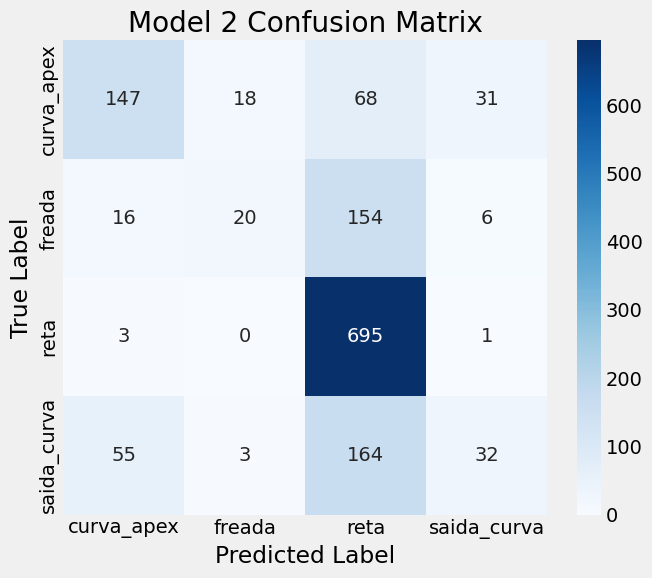

In [105]:
cm2 = confusion_matrix(all_labels2, all_preds2)
plt.figure(figsize=(7, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=val_data.classes, yticklabels=val_data.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Model 2 Confusion Matrix')
plt.tight_layout()
plt.show()

## Model 3 - n_features = 10

In [100]:
torch.manual_seed(13)

# Model/Architecture
model3_cnn2 = CNN2(n_feature=10, p=0.3) #changed n_feature from 5 to 10

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
optimizer3_cnn2 = optim.Adam(model3_cnn2.parameters(), lr=3e-4)

In [101]:
arch3_cnn2 = Architecture(model3_cnn2,
                        multi_loss_fn,
                        optimizer3_cnn2)
arch3_cnn2.set_loaders(train_loader, val_loader)
arch3_cnn2.train(8)

Model 3 took 52 minutes to train 8 epochs

## Model 3 - Visualize layers

In [102]:
featurizer_layers = ['conv1','conv2', 'relu1', 'maxp1','maxp2', 'flatten']
classifier_layers = ['fc1', 'relu2', 'fc2']

arch3_cnn2.attach_hooks(
  layers_to_hook=featurizer_layers + classifier_layers
)

images_batch, labels_batch = next(iter(val_loader))
logits = arch3_cnn2.predict(images_batch)
predicted = np.argmax(logits, 1)

arch3_cnn2.remove_hooks()

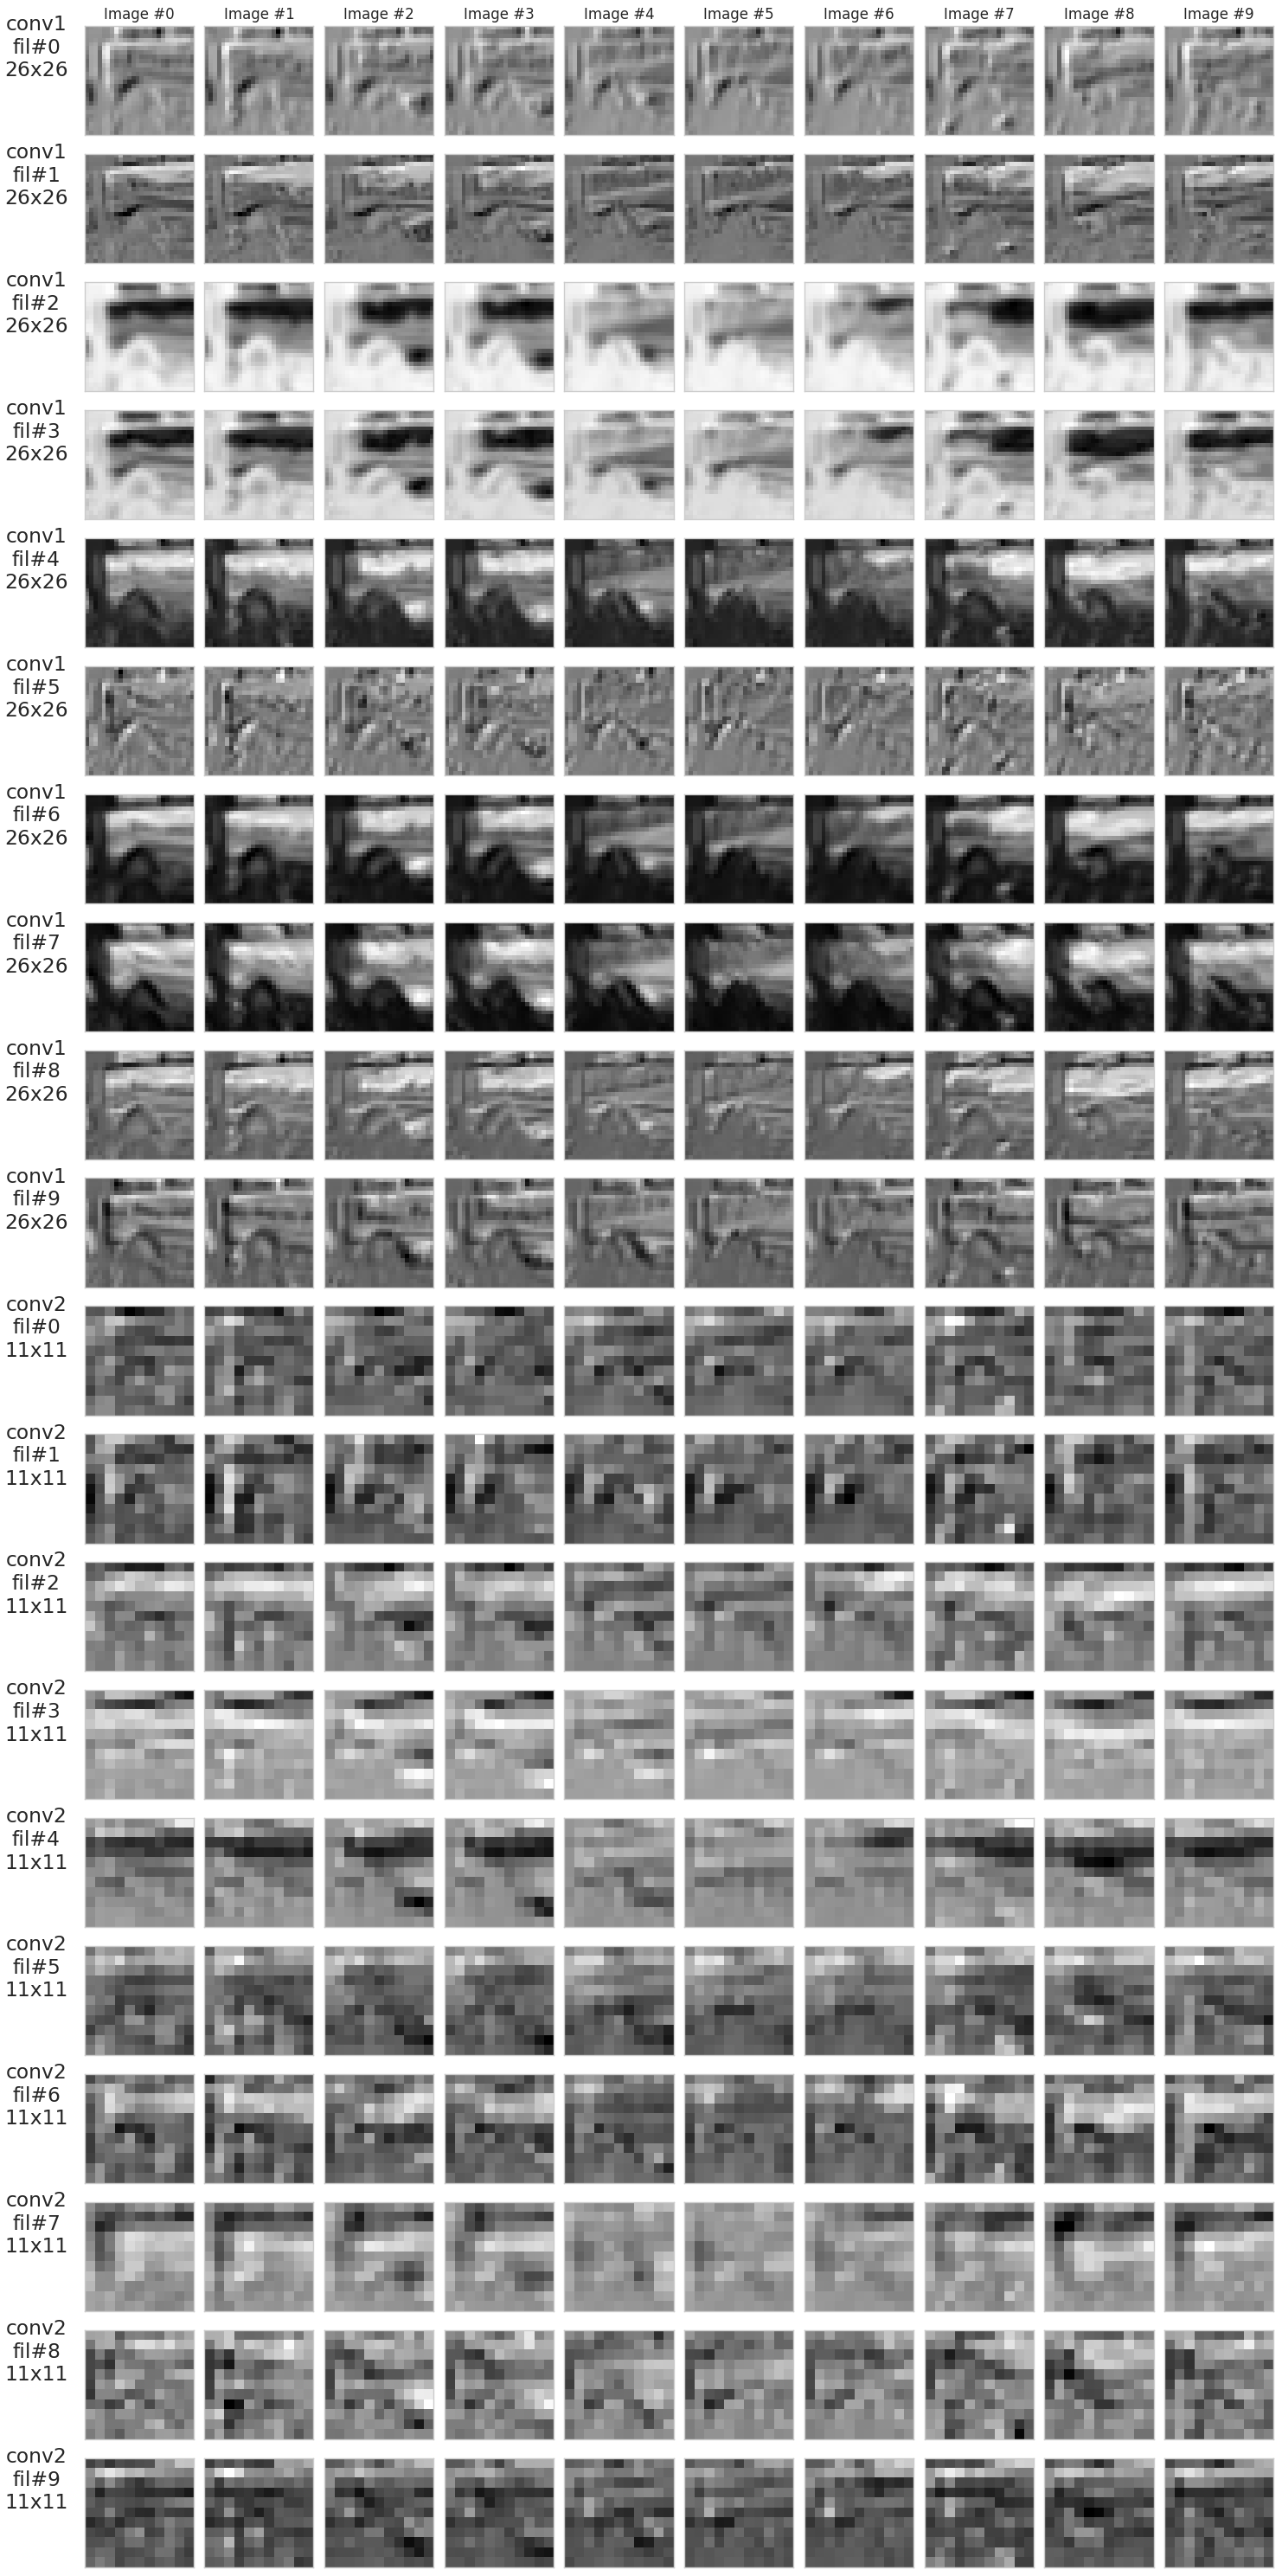

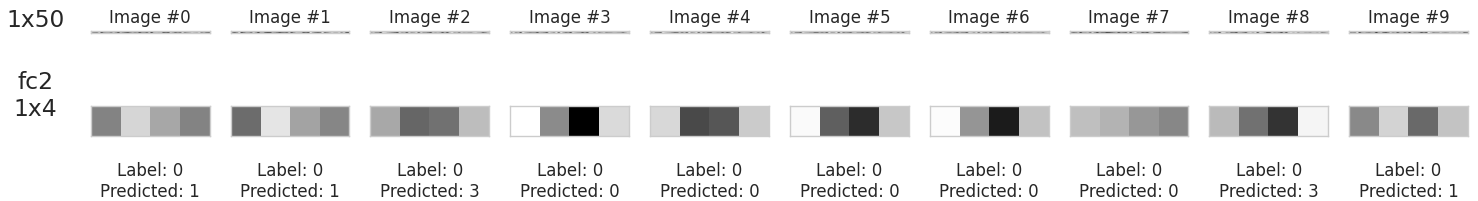

In [103]:
with plt.style.context('seaborn-v0_8-whitegrid'):
    fig_maps1 = arch3_cnn2.visualize_outputs(featurizer_layers)
    fig_maps2 = arch3_cnn2.visualize_outputs(
                  classifier_layers, y=labels_batch, yhat=predicted
                )

## Model 3 Accuracy

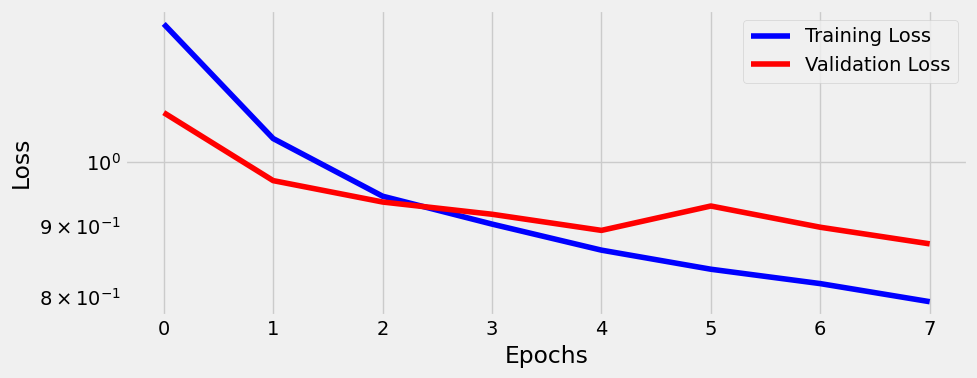

In [108]:
torch.save(model3_cnn2.state_dict(), 'model3_cnn2.pth')

fig = arch3_cnn2.plot_losses()

In [111]:
correct_counts3 = Architecture.loader_apply(val_loader, arch3_cnn2.correct)
correct_counts3

tensor([[159, 264],
        [ 68, 196],
        [653, 699],
        [ 50, 254]])

tensor([[159, 264],
        [ 68, 196],
        [653, 699],
        [ 50, 254]])

In [109]:
# Get all predictions and true labels from the validation set
all_preds3 = []
all_labels3 = []

arch3_cnn2.model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        logits = arch3_cnn2.predict(images)
        preds = np.argmax(logits, axis=1)
        all_preds3.extend(preds)
        all_labels3.extend(labels.cpu().numpy())

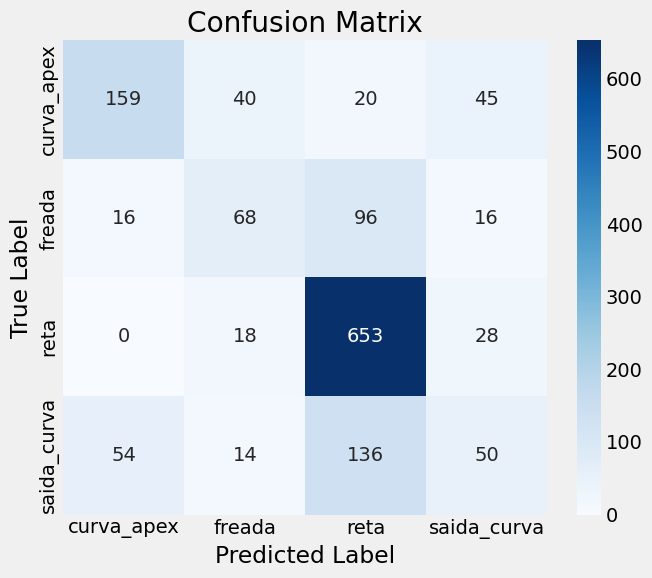

In [110]:
cm3 = confusion_matrix(all_labels3, all_preds3)
plt.figure(figsize=(7, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=val_data.classes, yticklabels=val_data.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Retraining the models with shuffle = false

Let's investigate the models outputs when not shuffling the dataloader

In [25]:
# Define a pipeline of image transformations:
# 1) Resize each image to 28×28 pixels
# 2) Ensure the output is a PIL/torchvision image (dropping any alpha channel)
# 3) Cast pixels to float32 and scale from [0–255] to [0.0–1.0]
# 4) Apply the user-defined normalization (e.g., mean/std normalization)
composer = Compose([
    Resize([28,28]),                         # Resize to 28×28
    ToImage(),                          # Convert to PIL Image in RGB
    ToDtype(torch.float32, scale=True), # Cast to float32 and normalize to [0,1]
    normalizer                          # Apply custom normalization transform
])

# Instantiate training and validation datasets from folders:
# - 'train_dataset_iracing' contains subfolders per class for training
# - 'test_dataset_iracing' likewise for validation
train_data = ImageFolder(root='train_dataset_iracing', transform=composer)
val_data   = ImageFolder(root='test_dataset_iracing', transform=composer)

# Wrap datasets in DataLoaders for batching and shuffling:
# - batch_size=16 yields mini-batches of 16 images
# - shuffle=True randomizes training order each epoch
train_loader_2 = DataLoader(train_data, batch_size=16, shuffle=False)#change shuffle to False for train_loader_2
val_loader   = DataLoader(val_data,   batch_size=16)  # no shuffle for validation

## Models configuration

In [24]:
#Model 1
torch.manual_seed(13)
# Model/Architecture
model_cnn2 = CNN2(n_feature=5, p=0.3)
# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
# Optimizer
optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=3e-4)

#Model 2
# Model/Architecture
model2_cnn2 = CNN2(n_feature=3, p=0.3)
# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
# Optimizer
optimizer2_cnn2 = optim.Adam(model2_cnn2.parameters(), lr=3e-4)

#Model 3
# Model/Architecture
model3_cnn2 = CNN2(n_feature=10, p=0.3)
# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
# Optimizer
optimizer3_cnn2 = optim.Adam(model3_cnn2.parameters(), lr=3e-4)

## Model train

In [26]:
#Model 1 Train
arch_cnn2 = Architecture(model_cnn2,
                        multi_loss_fn,
                        optimizer_cnn2)
arch_cnn2.set_loaders(train_loader_2, val_loader)
arch_cnn2.train(8)

it took 50 minutes to train model 1 without shuffling data

In [28]:
#Model 2 Train
arch2_cnn2 = Architecture(model2_cnn2,
                        multi_loss_fn,
                        optimizer2_cnn2)
arch2_cnn2.set_loaders(train_loader_2, val_loader)
arch2_cnn2.train(8)

In [29]:
#Model 3 Train
arch3_cnn2 = Architecture(model3_cnn2,
                        multi_loss_fn,
                        optimizer3_cnn2)
arch3_cnn2.set_loaders(train_loader_2, val_loader)
arch3_cnn2.train(8)

## Model accuracy

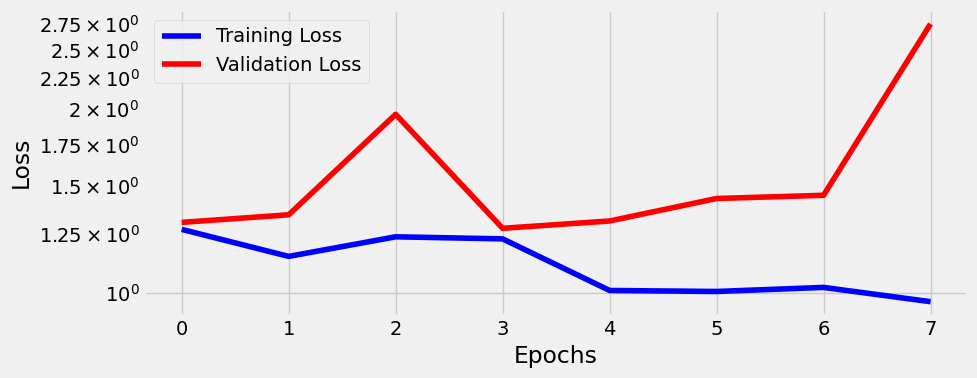

In [27]:
#Model 1 Save
torch.save(model_cnn2.state_dict(), 'model_cnn2_noshuffle.pth')

fig = arch_cnn2.plot_losses()

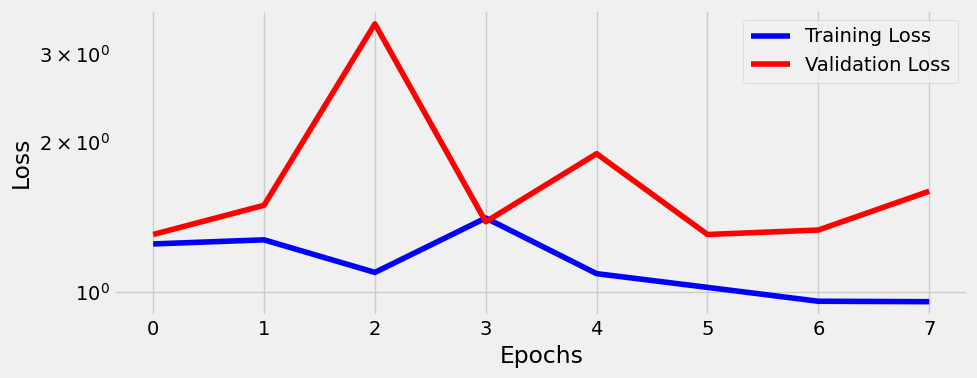

In [30]:
#Model 2 Save
torch.save(model2_cnn2.state_dict(), 'model2_cnn2_noshuffle.pth')

fig = arch2_cnn2.plot_losses()

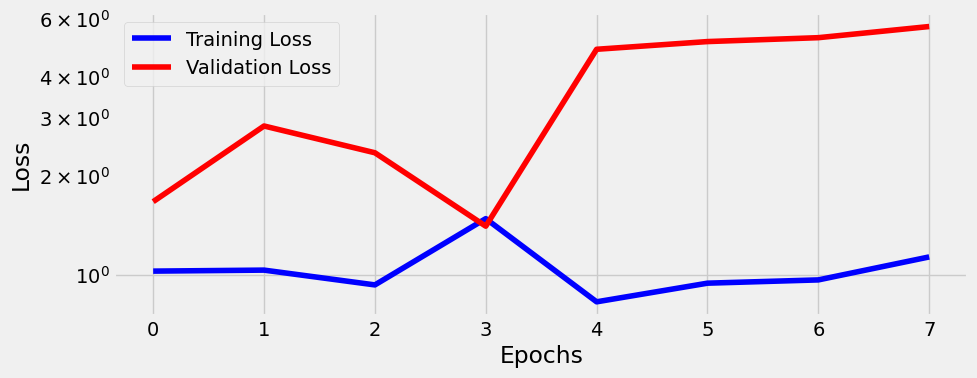

In [31]:
#Model 3 Save
torch.save(model3_cnn2.state_dict(), 'model3_cnn2_noshuffle.pth')

fig = arch3_cnn2.plot_losses()

In [32]:
correct_counts = Architecture.loader_apply(val_loader, arch_cnn2.correct)
correct_counts

tensor([[  0, 264],
        [  0, 196],
        [  0, 699],
        [254, 254]])

In [33]:
correct_counts2 = Architecture.loader_apply(val_loader, arch2_cnn2.correct)
correct_counts2

tensor([[  0, 264],
        [  0, 196],
        [ 13, 699],
        [251, 254]])

In [34]:
correct_counts3 = Architecture.loader_apply(val_loader, arch3_cnn2.correct)
correct_counts3

tensor([[  0, 264],
        [  0, 196],
        [  0, 699],
        [254, 254]])

In [35]:
# Get all predictions and true labels from the validation set
all_preds = []
all_labels = []

all_preds2 = []
all_labels2 = []

all_preds3 = []
all_labels3 = []

arch_cnn2.model.eval()
arch2_cnn2.model.eval()
arch3_cnn2.model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        logits = arch_cnn2.predict(images)
        preds = np.argmax(logits, axis=1)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

with torch.no_grad():
    for images, labels in val_loader:
        logits = arch2_cnn2.predict(images)
        preds = np.argmax(logits, axis=1)
        all_preds2.extend(preds)
        all_labels2.extend(labels.cpu().numpy())

with torch.no_grad():
    for images, labels in val_loader:
        logits = arch3_cnn2.predict(images)
        preds = np.argmax(logits, axis=1)
        all_preds3.extend(preds)
        all_labels3.extend(labels.cpu().numpy())

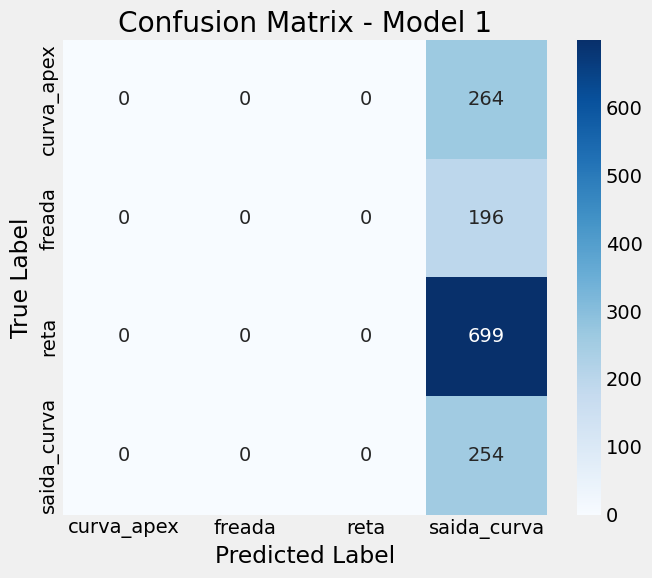

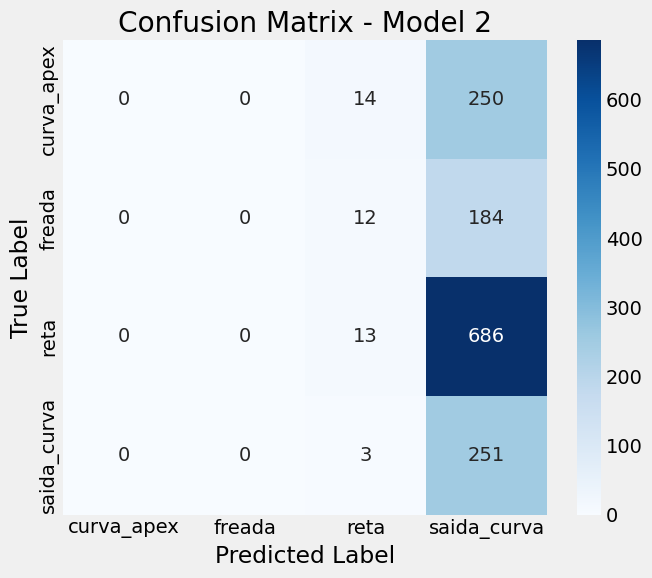

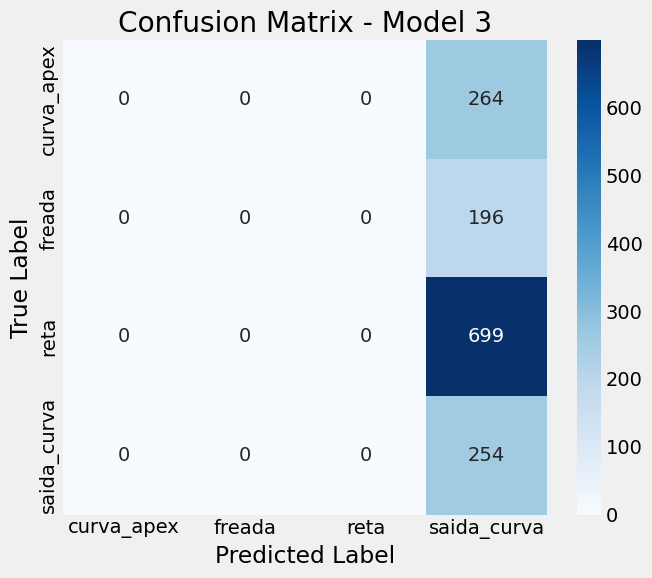

In [38]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_data.classes, yticklabels=val_data.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Model 1')
plt.tight_layout()
plt.show()

cm2 = confusion_matrix(all_labels2, all_preds2)
plt.figure(figsize=(7, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=val_data.classes, yticklabels=val_data.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Model 2')
plt.tight_layout()
plt.show()

cm3 = confusion_matrix(all_labels3, all_preds3)
plt.figure(figsize=(7, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=val_data.classes, yticklabels=val_data.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Model 3')
plt.tight_layout()
plt.show()

# Third task - Base model + new featurized blocks

In order to execute this task it will be necessary to modify CNN2 class in to CNN3 above.

This code addes two more featurizing block at the end of convulotional layer 2.

However, to accommodate four identical convolutional blocks (Conv2d() with kernel_size=3 followed by MaxPool2d with kernel_size=2), the minimum feasible input image size is 124x124 pixels.

The flatten layer remains the same:  `n_features * 5 * 5`

With an input of this size, the feature map can be processed through all four blocks without its dimensions shrinking to a size smaller than the convolutional kernel.

In [20]:
# Define a pipeline of image transformations:
# 1) Resize each image to 46×46 pixels
# 2) Ensure the output is a PIL/torchvision image (dropping any alpha channel)
# 3) Cast pixels to float32 and scale from [0–255] to [0.0–1.0]
# 4) Apply the user-defined normalization (e.g., mean/std normalization)
composer = Compose([
    Resize([124,124]),                         # Resize to 46×46
    ToImage(),                          # Convert to PIL Image in RGB
    ToDtype(torch.float32, scale=True), # Cast to float32 and normalize to [0,1]
    normalizer                          # Apply custom normalization transform
])

# Instantiate training and validation datasets from folders:
# - 'train_dataset_iracing' contains subfolders per class for training
# - 'test_dataset_iracing' likewise for validation
train_data_2 = ImageFolder(root='train_dataset_iracing', transform=composer)
val_data_2   = ImageFolder(root='test_dataset_iracing', transform=composer)

# Wrap datasets in DataLoaders for batching and shuffling:
# - batch_size=16 yields mini-batches of 16 images
# - shuffle=True randomizes training order each epoch
train_loader_2 = DataLoader(train_data_2, batch_size=16, shuffle=True)
val_loader_2   = DataLoader(val_data_2,   batch_size=16)  # no shuffle for validation

In [21]:
# the second element of this tuple is the label
train_data_2[0][0].shape, train_data_2[0][1]

(torch.Size([3, 124, 124]), 0)

It was added in CNN3 below the third and forth convolutional block. These blocks are equal to 
 
``` Python
        # Convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
``` 

In [ ]:
class CNN3(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN3, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        
        
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 4)  # Changed from 3 to 4 classes
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> max_pool2d n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) #n_feature@13x13
        
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Third convolutional block
        # n_feature@26x26 -> n_feature@13x13
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # Forth convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier

        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        
        # Output Layer
        # Input dimension (50)
        # Output dimension (4)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

## Model configuration

In [23]:
torch.manual_seed(13)

# Model/Architecture
model4_cnn3 = CNN3(n_feature=5, p=0.3) #n_feature remains 5. Change CNN3

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
optimizer_cnn3 = optim.Adam(model4_cnn3.parameters(), lr=3e-4)

In [24]:
arch4_cnn2 = Architecture(model4_cnn3,
                        multi_loss_fn,
                        optimizer_cnn3)
arch4_cnn2.set_loaders(train_loader_2, val_loader_2)
arch4_cnn2.train(8)

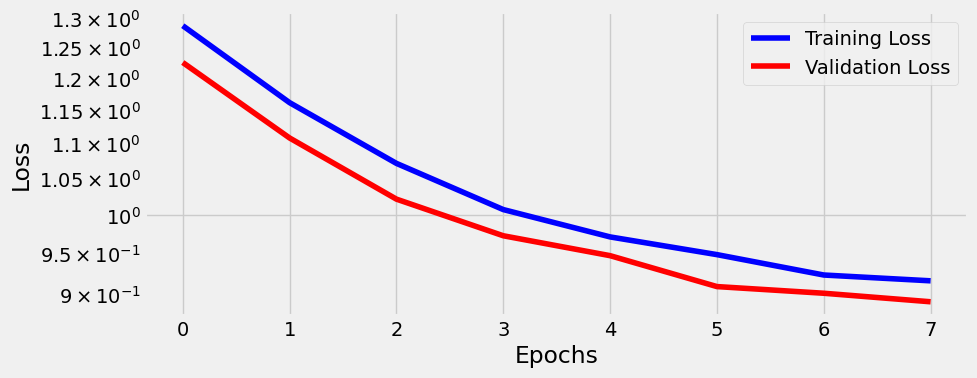

In [26]:
#Model 4 Save
torch.save(model4_cnn3.state_dict(), 'model4_cnn3.pth')

fig = arch4_cnn2.plot_losses()

In [25]:
correct_counts4 = Architecture.loader_apply(val_loader_2, arch4_cnn2.correct)
correct_counts4

tensor([[193, 264],
        [ 38, 196],
        [678, 699],
        [ 16, 254]])

it took 61 minutes to train model 4 during 8 epochs

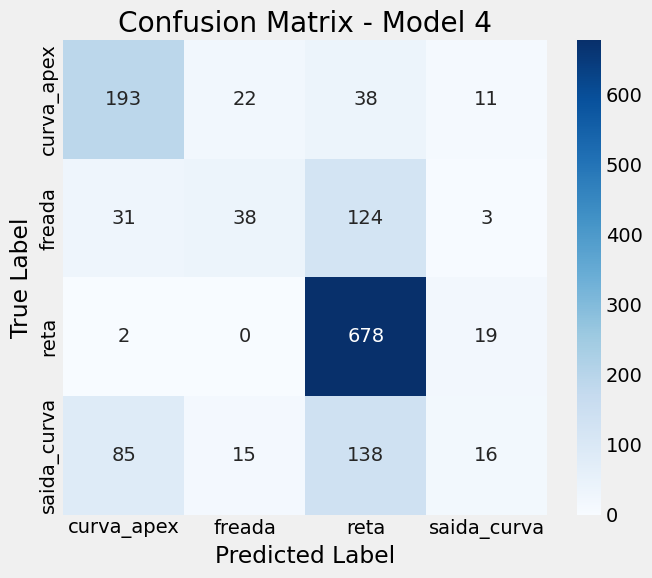

In [27]:
# Plot confusion matrix for Model 4
all_preds4 = []
all_labels4 = []
arch4_cnn2.model.eval()

with torch.no_grad():
    for images, labels in val_loader_2:
        logits = arch4_cnn2.predict(images)
        preds = np.argmax(logits, axis=1)
        all_preds4.extend(preds)
        all_labels4.extend(labels.cpu().numpy())
cm4 = confusion_matrix(all_labels4, all_preds4)
plt.figure(figsize=(7, 6))
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues', xticklabels=val_data_2.classes, yticklabels=val_data_2.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Model 4')
plt.tight_layout()
plt.show()

# Comparing Models

Comparison among all 4 trained models in this project

In [ ]:
# Load all models' weights
model_cnn2.load_state_dict(torch.load('base_model_cnn2.pth'))
model2_cnn2.load_state_dict(torch.load('model2_cnn2.pth'))
model3_cnn2.load_state_dict(torch.load('model3_cnn2.pth'))
model4_cnn3.load_state_dict(torch.load('model4_cnn3.pth'))

# Set models to evaluation mode
model_cnn2.eval()
model2_cnn2.eval()
model3_cnn2.eval()
model4_cnn3.eval()

# Helper function to compute accuracy
def compute_accuracy(all_labels, all_preds):
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    return (all_labels == all_preds).sum() / len(all_labels)

# Model 1 (CNN2, n_feature=5, 28x28)
all_preds1, all_labels1 = [], []
with torch.no_grad():
    for images, labels in val_loader:
        logits = model_cnn2(images)
        preds = torch.argmax(logits, axis=1)
        all_preds1.extend(preds.cpu().numpy())
        all_labels1.extend(labels.cpu().numpy())
acc1 = compute_accuracy(all_labels1, all_preds1)

# Model 2 (CNN2, n_feature=3, 28x28)
all_preds2, all_labels2 = [], []
with torch.no_grad():
    for images, labels in val_loader:
        logits = model2_cnn2(images)
        preds = torch.argmax(logits, axis=1)
        all_preds2.extend(preds.cpu().numpy())
        all_labels2.extend(labels.cpu().numpy())
acc2 = compute_accuracy(all_labels2, all_preds2)

# Model 3 (CNN2, n_feature=10, 28x28)
all_preds3, all_labels3 = [], []
with torch.no_grad():
    for images, labels in val_loader:
        logits = model3_cnn2(images)
        preds = torch.argmax(logits, axis=1)
        all_preds3.extend(preds.cpu().numpy())
        all_labels3.extend(labels.cpu().numpy())
acc3 = compute_accuracy(all_labels3, all_preds3)

# Model 4 (CNN3, n_feature=5, 124x124)
all_preds4, all_labels4 = [], []
with torch.no_grad():
    for images, labels in val_loader_2:
        logits = model4_cnn3(images)
        preds = torch.argmax(logits, axis=1)
        all_preds4.extend(preds.cpu().numpy())
        all_labels4.extend(labels.cpu().numpy())
acc4 = compute_accuracy(all_labels4, all_preds4)

# Print insights
print(f"Model 1 (CNN2, n_feature=5, 28x28):   Accuracy = {acc1:.3f}")
print(f"Model 2 (CNN2, n_feature=3, 28x28):   Accuracy = {acc2:.3f}")
print(f"Model 3 (CNN2, n_feature=10, 28x28):  Accuracy = {acc3:.3f}")
print(f"Model 4 (CNN3, n_feature=5, 124x124): Accuracy = {acc4:.3f}")

# Insight
print("\nInsight:")
print("Increasing the number of features from 3 to 5 to 10 in CNN2 shows how model capacity affects accuracy.")
print("Model 4 (CNN3) with deeper architecture and larger input size achieves different performance,")
print("highlighting the impact of both network depth and input resolution on classification accuracy.")

# Task 4 - Resizing image to 128x128

## CNN4 CLASS

In [6]:
class CNN4(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN4, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        # Creates the linear layers
        # Where do this 115 * 63 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 30 * 30, 128)
        self.fc2 = nn.Linear(128, 4)  # Changed from 3 to 4 classes
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) #maxpool kernel size 3
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) #maxpool kernel size 2
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (4)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

## Import image folder

## Temp transform for normalization

In [7]:
# Compose a sequence of preprocessing transforms
# 1) Resize images to 28×28 pixels
# 2) Ensure output is a PIL/torchvision Image (dropping any alpha channel)
# 3) Convert pixel values to float32 and scale from [0–255] to [0.0–1.0]
temp_transform = Compose([
    Resize([128,128]),                        # Resize each image to 28×28
    ToImage(),                         # Convert tensor back to PIL Image (enforces RGB)
    ToDtype(torch.float32, scale=True) # Cast to float32 and normalize pixel range
])

# Create an ImageFolder dataset from the 'rps' directory
# Images are grouped by subfolder name as class labels, and each image is transformed
temp_dataset = ImageFolder(
    root='train_dataset_iracing',
    transform=temp_transform          # Apply the preprocessing pipeline to every image
)

In [8]:
# the second element of this tuple is the label
temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 128, 128]), 0)

In [9]:
# Get total number of samples in the dataset
dataset_size = len(temp_dataset)
print(f"Dataset size: {dataset_size} images")

# Get number of classes
num_classes = len(temp_dataset.classes)
print(f"Number of classes: {num_classes}")

Dataset size: 7926 images
Number of classes: 4


## Standardization

In [7]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

In [27]:
# we can compute the average mean value and the average standard deviation, per channel.
# make_normalizer() is a method that takes a data loader and returns an instance of the Normalize() transform
normalizer_4 = Architecture.make_normalizer(temp_loader)
normalizer_4

Normalize(mean=[tensor(0.2624), tensor(0.2789), tensor(0.2882)], std=[tensor(0.2655), tensor(0.2874), tensor(0.3076)], inplace=False)

Using 128x128 size images we got Mean and Std below:

* mean=[tensor(0.2624), tensor(0.2789), tensor(0.2882)],
* Std=[tensor(0.2756), tensor(0.2969), tensor(0.3162)],

In [10]:
# Save normalization values as normalize2 (as tensors)
normalizer_4 = Normalize(
    mean=torch.tensor([0.2624, 0.2789, 0.2882]),
    std=torch.tensor([0.2655, 0.2874, 0.3076]),
    inplace=False
)
normalizer_4

Normalize(mean=[tensor(0.2624), tensor(0.2789), tensor(0.2882)], std=[tensor(0.2655), tensor(0.2874), tensor(0.3076)], inplace=False)

In [11]:
# Define a pipeline of image transformations:
# 1) Resize each image to 480×270 pixels
# 2) Ensure the output is a PIL/torchvision image (dropping any alpha channel)
# 3) Cast pixels to float32 and scale from [0–255] to [0.0–1.0]
# 4) Apply the user-defined normalization (e.g., mean/std normalization)
composer = Compose([
    Resize([128,128]),                         # Resize to 128×128
    ToImage(),                          # Convert to PIL Image in RGB
    ToDtype(torch.float32, scale=True), # Cast to float32 and normalize to [0,1]
    normalizer_4                         # Apply custom normalization transform
])

# Instantiate training and validation datasets from folders:
# - 'train_dataset_iracing' contains subfolders per class for training
# - 'test_dataset_iracing' likewise for validation
train_data = ImageFolder(root='train_dataset_iracing', transform=composer)
val_data   = ImageFolder(root='test_dataset_iracing', transform=composer)

# Wrap datasets in DataLoaders for batching and shuffling:
# - batch_size=16 yields mini-batches of 16 images
# - shuffle=True randomizes training order each epoch
train_loader_3 = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader_3   = DataLoader(val_data,   batch_size=16)  # no shuffle for validation

## Model Configuration

In [32]:
torch.manual_seed(13)

# Model/Architecture
base_model2_cnn4 = CNN4(n_feature=5, p=0.3)

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
base_optimizer_cnn4 = optim.Adam(base_model2_cnn4.parameters(), lr=3e-4)

## Model training

In [33]:
arch_cnn4 = Architecture(base_model2_cnn4,
                        multi_loss_fn,
                        base_optimizer_cnn4)
arch_cnn4.set_loaders(train_loader_3, val_loader_3)
arch_cnn4.train(7)

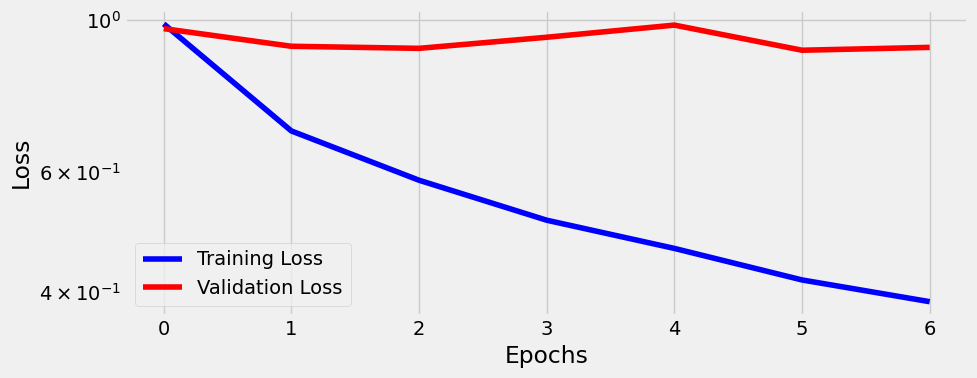

In [34]:
torch.save(base_model2_cnn4.state_dict(), 'base_model2_cnn4.pth')

fig = arch_cnn4.plot_losses()

## Model 2 and 3 - changing number of features

In [37]:
#Model 2
torch.manual_seed(13)

# Model/Architecture
model2_cnn4 = CNN4(n_feature=3, p=0.3) #changed n_feature from 5 to 3

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
optimizer2_cnn4 = optim.Adam(model2_cnn4.parameters(), lr=3e-4)   

In [38]:
arch2_cnn4 = Architecture(model2_cnn4,
                        multi_loss_fn,
                        optimizer2_cnn4)
arch2_cnn4.set_loaders(train_loader_3, val_loader_3)
arch2_cnn4.train(7)

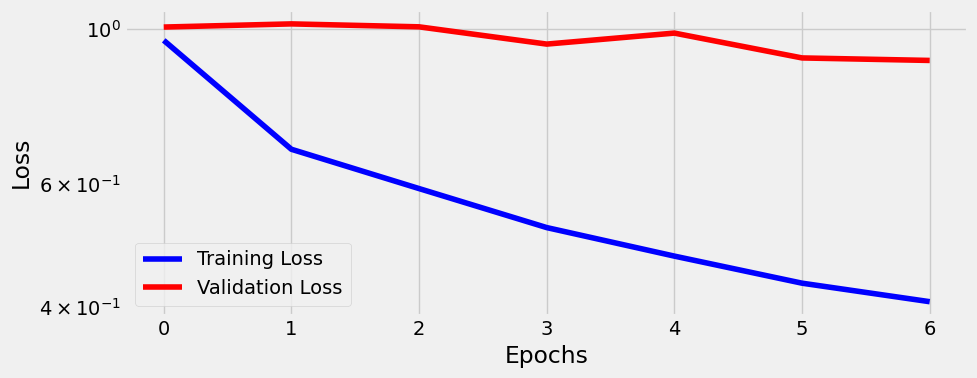

In [39]:
torch.save(model2_cnn4.state_dict(), 'model2_cnn4.pth')

fig = arch2_cnn4.plot_losses()

In [ ]:
#Model 3
torch.manual_seed(13)
# Model/Architecture
model3_cnn4 = CNN4(n_feature=10, p=0.3) #changed n_feature from 5 to 10
# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
# Optimizer
optimizer3_cnn4 = optim.Adam(model3_cnn4.parameters(), lr=3e-4)


_IncompleteInputError: incomplete input (656929677.py, line 16)

In [41]:
arch3_cnn4 = Architecture(model3_cnn4,
                        multi_loss_fn,
                        optimizer3_cnn4)
arch3_cnn4.set_loaders(train_loader_3, val_loader_3)
arch3_cnn4.train(7)

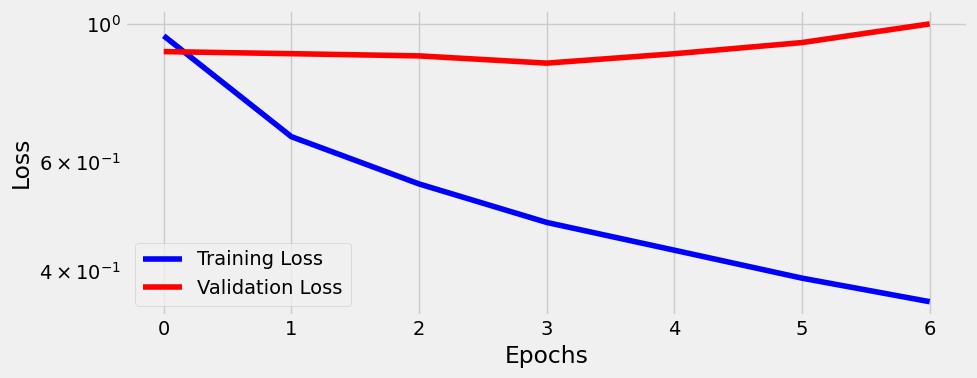

In [42]:
#Plot losses for model 3
torch.save(model3_cnn4.state_dict(), 'model3_cnn4.pth')
fig = arch3_cnn4.plot_losses()


## Load models

In [12]:
torch.manual_seed(13)

# Model/Architecture
base_model2_cnn4 = CNN4(n_feature=5, p=0.3)
model2_cnn4 = CNN4(n_feature=3, p=0.3) #changed n_feature from 5 to 3
model3_cnn4 = CNN4(n_feature=10, p=0.3) #changed n_feature from 5 to 10

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
base_optimizer_cnn4 = optim.Adam(base_model2_cnn4.parameters(), lr=3e-4)
optimizer2_cnn4 = optim.Adam(model2_cnn4.parameters(), lr=3e-4)   
optimizer3_cnn4 = optim.Adam(model3_cnn4.parameters(), lr=3e-4)




In [13]:
# Load weights for all three CNN4 models
base_model2_cnn4.load_state_dict(torch.load('base_model2_cnn4.pth'))
model2_cnn4.load_state_dict(torch.load('model2_cnn4.pth'))
model3_cnn4.load_state_dict(torch.load('model3_cnn4.pth'))

#Load Architecture
arch_cnn4 = Architecture(base_model2_cnn4,
                        multi_loss_fn,
                        base_optimizer_cnn4)
arch_cnn4.set_loaders(train_loader_3, val_loader_3)

arch2_cnn4 = Architecture(model2_cnn4,
                        multi_loss_fn,
                        optimizer2_cnn4)
arch2_cnn4.set_loaders(train_loader_3, val_loader_3)

arch3_cnn4 = Architecture(model3_cnn4,
                        multi_loss_fn,
                        optimizer3_cnn4)
arch3_cnn4.set_loaders(train_loader_3, val_loader_3)

# Set models to evaluation mode
base_model2_cnn4.eval()
model2_cnn4.eval()
model3_cnn4.eval()

CNN4(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)

## Models Accuracy

# Task 5 - Increase number of blocks

In order to execute this task it will be necessary to modify CNN4 class in to CNN5 below.

This code addes two more featurizing block at the end of convulotional layer 2.

However, to accommodate four identical convolutional blocks (Conv2d() with kernel_size=5 followed by MaxPool2d with kernel_size=2), the minimum feasible input image size is 64x64 pixels.

Therefore, our size reduction to `128x128` still works.
With an input of this size, the feature map can be processed through all four blocks without its dimensions shrinking to a size smaller than the convolutional kernel.

The flatten layer remains the same:  `n_features * 5 * 5`



## CNN5 Class

It was added in CNN3 below the third and forth convolutional block. These blocks are equal to 
 
``` Python
        # Convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
``` 

In [14]:
class CNN5(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN5, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=5)
        
        # Creates the linear layers
        # input n_feature * 5 * 5 = 125
        # output 128 neurons
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 4)  # Changed from 3 to 4 classes
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> max_pool2d n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) #n_feature@13x13
        
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Third convolutional block
        # n_feature@26x26 -> n_feature@13x13
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # Forth convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier

        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        
        # Output Layer
        # Input dimension (50)
        # Output dimension (4)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

## Model 4


In [37]:
# Model 4
torch.manual_seed(13)

# Model/Architecture
model4_cnn5 = CNN5(n_feature=5, p=0.3)

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
optimizer4_cnn5 = optim.Adam(model4_cnn5.parameters(), lr=3e-4)



In [38]:
# Architecture
arch4_cnn5 = Architecture(model4_cnn5,
                          multi_loss_fn,
                          optimizer4_cnn5)
arch4_cnn5.set_loaders(train_loader_3, val_loader_3)
arch4_cnn5.train(7)

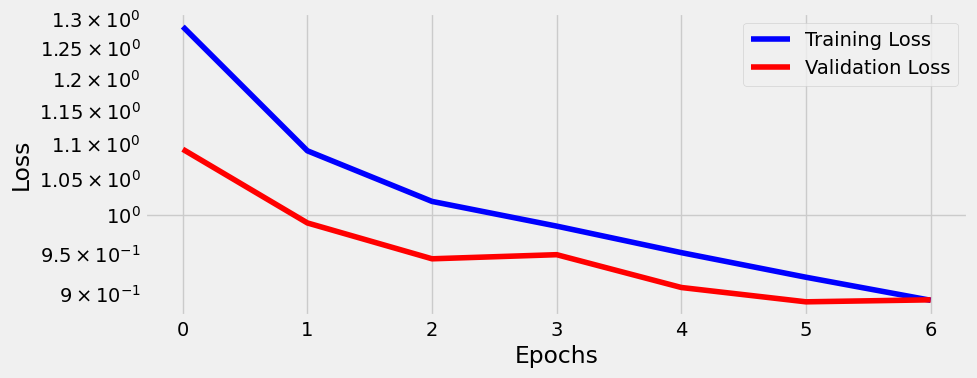

In [39]:
#Plot losses for model 4
torch.save(model4_cnn5.state_dict(), 'model4_cnn5.pth')
fig = arch4_cnn5.plot_losses()


In [15]:
#configure model 4
model4_cnn5 = CNN5(n_feature=5, p=0.3) #n_feature remains 5. Change CNN5
# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
# Optimizer
optimizer4_cnn5 = optim.Adam(model4_cnn5.parameters(), lr=3e-4)

#Load model 4
model4_cnn5.load_state_dict(torch.load('model4_cnn5.pth'))

#load architecture for model 4
arch4_cnn5 = Architecture(model4_cnn5,
                          multi_loss_fn,
                          optimizer4_cnn5)
arch4_cnn5.set_loaders(train_loader_3, val_loader_3)

# Set model to evaluation mode
model4_cnn5.eval()

CNN5(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(5, 5, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=125, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=4, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)

# Models Accuracy

In [ ]:
correct_counts = Architecture.loader_apply(val_loader_3, arch_cnn4.correct)
correct_counts

tensor([[ 95, 264],
        [ 95, 196],
        [604, 699],
        [130, 254]])

In [ ]:
correct_counts2 = Architecture.loader_apply(val_loader_3, arch2_cnn4.correct)
correct_counts2

tensor([[138, 264],
        [117, 196],
        [536, 699],
        [112, 254]])

In [ ]:
correct_counts3 = Architecture.loader_apply(val_loader_3, arch3_cnn4.correct)
correct_counts3

tensor([[133, 264],
        [144, 196],
        [457, 699],
        [131, 254]])

In [41]:
correct_counts4 = Architecture.loader_apply(val_loader_3, arch4_cnn5.correct)
correct_counts4

tensor([[125, 264],
        [ 20, 196],
        [664, 699],
        [ 73, 254]])

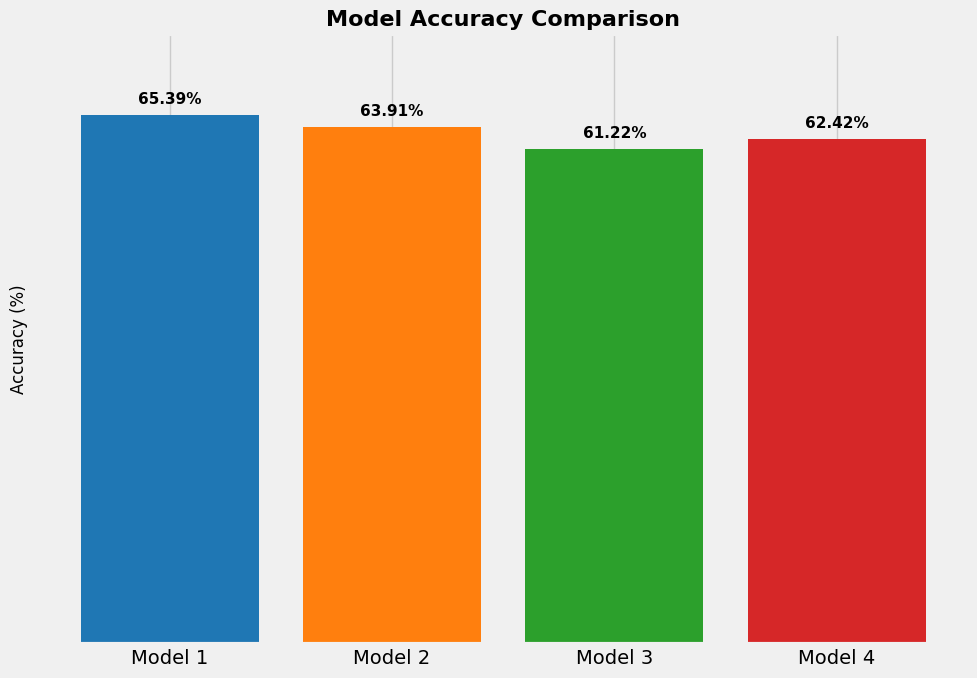

Model 1: Accuracy of 65.39%
Model 2: Accuracy of 63.91%
Model 3: Accuracy of 61.22%
Model 4: Accuracy of 62.42%


In [42]:
# List of data to iterate through
models_data = [correct_counts, correct_counts2, correct_counts3, correct_counts4]
accuracies = []

# Calculate the accuracy for each model
for data in models_data:
    total_correct = data[:, 0].sum().item()
    total_samples = data[:, 1].sum().item()
    accuracy = (total_correct / total_samples) * 100  # Convert to percentage
    accuracies.append(accuracy)

# Step 2: Put image text in English
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(model_names, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c','#d62728'],)

# Add title and labels in English
ax.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_ylim(0, max(accuracies) + 10) # Set Y-axis limit slightly above the highest bar
ax.yaxis.grid(False)
ax.set_yticklabels([]) #remove y-tick labels for cleaner look

# Add the exact value on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 1.0, f'{yval:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Improve layout to prevent overlap
plt.tight_layout()

# Save the figure to a file
plt.savefig('model_accuracy_comparison.png')

# Show the plot
plt.show()

# Print the calculated values in English
for i, acc in enumerate(accuracies):
    print(f"{model_names[i]}: Accuracy of {acc:.2f}%")

We can see from graph above that the variation in number of feature (n) changes the model accuracy. The best model had accuracy of 65%, which is very low.

# Optimal Learning Rate



In [2]:
from torch_lr_finder import LRFinder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.53E-03


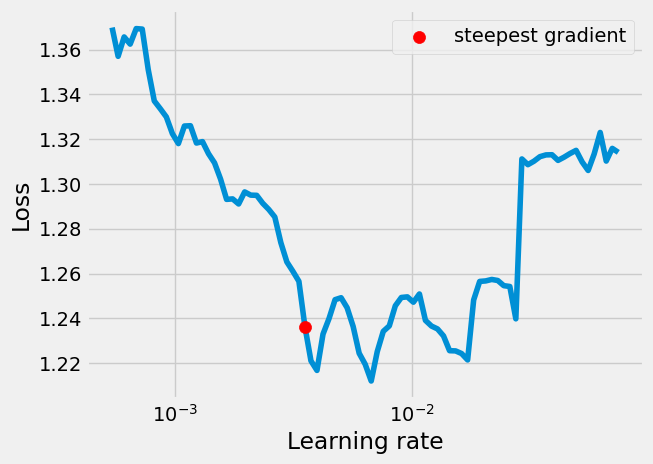

In [16]:
torch.manual_seed(11)
new_base_model = CNN4(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_base_model.parameters(), lr=3e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr_finder = LRFinder(
    new_base_model, new_optimizer, multi_loss_fn, device=device
)
lr_finder.range_test(train_loader_3, end_lr=1e-1, num_iter=100)
lr_finder.plot(log_lr=True)
lr_finder.reset()

Using the LR Finder with our models, it suggests to use lambda rate = `3.53e-3`

# Task - Retraining with new lambda rate

In this task we will calculate the training losses using the suggested lambda rate of 3.53E-3

In [19]:
# Set the suggested learning rate for all optimizers
suggested_lr = 3.53e-3

for optimizer in [base_optimizer_cnn4, optimizer2_cnn4, optimizer3_cnn4, optimizer4_cnn5]:
    for param_group in optimizer.param_groups:
        param_group['lr'] = suggested_lr

In [20]:
# Retrain Model 1 (n_feature=5)
arch_cnn4 = Architecture(base_model2_cnn4, multi_loss_fn, base_optimizer_cnn4)
arch_cnn4.set_loaders(train_loader_3, val_loader_3)
arch_cnn4.train(7)

# Save the retrained base model
torch.save(base_model2_cnn4.state_dict(), 'retrained_base_model2_cnn4.pth')

KeyboardInterrupt: 

In [ ]:
# Retrain Model 2 (n_feature=3)
arch2_cnn4 = Architecture(model2_cnn4, multi_loss_fn, optimizer2_cnn4)
arch2_cnn4.set_loaders(train_loader_3, val_loader_3)
arch2_cnn4.train(7)

#save the retrained model 2
torch.save(model2_cnn4.state_dict(), 'retrained_model2_cnn4.pth')


In [ ]:
# Retrain Model 3 (n_feature=10)
arch3_cnn4 = Architecture(model3_cnn4, multi_loss_fn, optimizer3_cnn4)
arch3_cnn4.set_loaders(train_loader_3, val_loader_3)
arch3_cnn4.train(7)

#save the retrained model 3
torch.save(model3_cnn4.state_dict(), 'retrained_model3_cnn4.pth')

In [ ]:
# Retrain Model 4 (n_feature=5)
arch4_cnn5 = Architecture(model4_cnn5, multi_loss_fn, optimizer4_cnn5)
arch4_cnn5.set_loaders(train_loader_3, val_loader_3)
arch4_cnn5.train(7)

#save the retrained model 4
torch.save(model4_cnn5.state_dict(), 'retrained_model4_cnn5.pth')   

## Plot losses

In [ ]:
#plot losses for retrained models
fig = arch_cnn4.plot_losses()
fig = arch2_cnn4.plot_losses()
fig = arch3_cnn4.plot_losses()
fig = arch4_cnn5.plot_losses()

## Models Accuracies

In [ ]:
# Evaluate the retrained models
correct_counts_retrained = Architecture.loader_apply(val_loader_3, arch_cnn4.correct)
correct_counts_retrained2 = Architecture.loader_apply(val_loader_3, arch2_cnn4.correct)
correct_counts_retrained3 = Architecture.loader_apply(val_loader_3, arch3_cnn4.correct)
correct_counts_retrained4 = Architecture.loader_apply(val_loader_3, arch4_cnn5.correct)
# Calculate accuracy for retrained models
def calculate_accuracy(correct_counts):
    total_correct = correct_counts[:, 0].sum().item()
    total_samples = correct_counts[:, 1].sum().item()
    return (total_correct / total_samples) * 100  # Convert to percentage
acc_retrained = calculate_accuracy(correct_counts_retrained)
acc_retrained2 = calculate_accuracy(correct_counts_retrained2)
acc_retrained3 = calculate_accuracy(correct_counts_retrained3)
acc_retrained4 = calculate_accuracy(correct_counts_retrained4)
# Print retrained model accuracies
print(f"Re-trained Model 1 (n_feature=5):   Accuracy = {acc_retrained:.2f}%")
print(f"Re-trained Model 2 (n_feature=3):   Accuracy = {acc_retrained2:.2f}%")
print(f"Re-trained Model 3 (n_feature=10):  Accuracy = {acc_retrained3:.2f}%")
print(f"Re-trained Model 4 (n_feature=5):   Accuracy = {acc_retrained4:.2f}%")